In [1]:
import requests
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get the word lists from the source code

r = requests.get('https://www.powerlanguage.co.uk/wordle/main.e65ce0a5.js')

# This regexp pulls the word lists out of the source
solutions, guesses = [re.findall('\w{5}', m.group(0)) for m in re.finditer('\[("\w{5}",?)+\]', r.text)]
guesses = guesses + solutions
len(solutions), len(guesses)

(2315, 12972)

In [3]:
# Write the word lists to local files

with open('solutions.txt', 'wt') as sol_file:
    sol_file.write('\n'.join(solutions))

with open('guesses.txt', 'wt') as guess_file:
    guess_file.write('\n'.join(guesses))


In [4]:
# Count the frequency of letters by position

appearances = {}

for word in solutions:
    for i, c in enumerate(word):
        count = appearances.get((c, i), 0) + 1
        appearances[(c, i)] = count

print(appearances)

{('c', 0): 198, ('i', 1): 202, ('g', 2): 67, ('a', 3): 163, ('r', 4): 212, ('r', 0): 105, ('e', 1): 242, ('b', 2): 57, ('u', 3): 82, ('t', 4): 253, ('s', 0): 366, ('s', 2): 80, ('s', 3): 171, ('y', 4): 364, ('h', 0): 69, ('u', 1): 186, ('m', 2): 61, ('p', 3): 50, ('h', 4): 139, ('a', 0): 141, ('w', 1): 44, ('a', 2): 307, ('k', 3): 55, ('e', 4): 424, ('b', 0): 173, ('l', 1): 201, ('u', 2): 165, ('f', 0): 136, ('o', 1): 279, ('c', 2): 56, ('l', 4): 156, ('e', 0): 72, ('v', 1): 15, ('d', 3): 69, ('n', 0): 37, ('a', 1): 304, ('v', 2): 49, ('r', 2): 163, ('v', 3): 46, ('t', 3): 139, ('d', 0): 111, ('r', 3): 152, ('f', 4): 26, ('m', 0): 107, ('d', 2): 75, ('e', 3): 318, ('k', 0): 20, ('m', 3): 68, ('a', 4): 64, ('t', 1): 77, ('i', 2): 266, ('n', 3): 182, ('k', 4): 113, ('g', 0): 115, ('r', 1): 267, ('q', 0): 23, ('n', 2): 139, ('c', 3): 152, ('b', 1): 16, ('g', 3): 76, ('n', 4): 130, ('j', 2): 3, ('o', 3): 132, ('e', 2): 177, ('o', 2): 244, ('l', 2): 112, ('t', 2): 111, ('p', 0): 142, ('s', 

In [5]:
# summarize the appearances

letter_counts = pd.DataFrame({chr(o): [appearances.get((chr(o), i), 0) for i in range(5)] for o in range (97, 97+26)}).T
letter_counts

,0,1,2,3,4
a,141,304,307,163,64
b,173,16,57,24,11
c,198,40,56,152,31
d,111,20,75,69,118
e,72,242,177,318,424
f,136,8,25,35,26
g,115,12,67,76,41
h,69,144,9,28,139
i,34,202,266,158,11
j,20,2,3,2,0


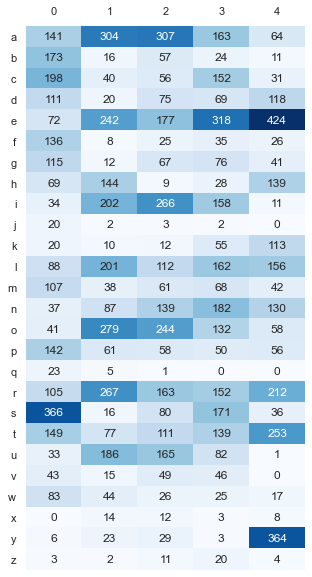

In [6]:

sns.set(rc = {'figure.figsize':(5,10)})
sns.heatmap(letter_counts, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.yticks(rotation=0) 
plt.tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

In [7]:


def get_green_ct(word):
    return sum([appearances.get((c, i), 0) for i, c in enumerate(word)])

greens = {word: get_green_ct(word) for word in guesses}
max(greens, key = greens.get)

'saree'

In [8]:
df = pd.DataFrame.from_dict(greens, orient='index').rename(columns={0: 'ct'})

(df['ct']/len(solutions)).nlargest(25)

saree    0.680346
sooey    0.678618
soree    0.669546
saine    0.666091
soare    0.660043
saice    0.653132
sease    0.652268
seare    0.644060
seine    0.639309
slane    0.639309
soole    0.637149
siree    0.636285
seise    0.634557
cooee    0.631965
soote    0.627214
soily    0.620734
slate    0.620734
soave    0.614255
samey    0.610367
semee    0.609503
sauce    0.609503
slice    0.608639
seame    0.607775
souse    0.606911
cooey    0.606048
Name: ct, dtype: float64

In [9]:
get_green_ct('eeeee')

1233

In [10]:
word = 'saree'
for i, c in enumerate(word):
    print (appearances.get((c, i), 0))

366
304
163
318
424


In [11]:
def grade_guess(sol, guess):
    response = []
    for i, c in enumerate(guess):
        if sol[i] == c:
            response.append(True)
        elif c in sol:
            response.append(False)
        else:
            response.append(None)
    return tuple(response)

grade_guess('panic', 'disco')

(None, False, None, False, None)

In [12]:
grade_guess('panic', 'paint')

(True, True, False, False, None)

In [13]:

def grade_seed_word(guess):
    grades = {sol: grade_guess(sol, guess) for sol in solutions}

    # Now look for matches
    avg_matches = sum(sum(grades[sol] == g for g in grades.values()) for sol in solutions)/len(solutions)
    print(guess, avg_matches)
    return avg_matches

avg_matches = {guess: grade_seed_word(guess) for guess in guesses}


print(avg_matches)

        

aahed 194.8401727861771
aalii 312.33563714902806
aargh 248.68984881209502
aarti 151.414686825054
abaca 509.71274298056153
abaci 292.28034557235424
abacs 296.1257019438445
abaft 346.8479481641469
abaka 650.1550755939525
abamp 435.16069114470844
aband 330.60777537796974
abash 305.88725701943844
abask 375.98833693304533
abaya 532.7321814254859
abbas 472.54470842332614
abbed 259.45788336933043
abbes 205.42246220302377
abcee 204.9170626349892
abeam 276.3002159827214
abear 180.64665226781858
abele 185.5684665226782
abers 115.1658747300216
abets 128.30799136069115
abies 107.96155507559395
abler 107.98401727861771
ables 118.3745140388769
ablet 107.6012958963283
ablow 239.741252699784
abmho 270.9403887688985
abohm 253.76198704103672
aboil 153.2341252699784
aboma 354.9386609071274
aboon 286.9879049676026
abord 170.84967602591792
abore 97.46479481641468
abram 310.0021598272138
abray 271.79568034557235
abrim 181.27818574514038
abrin 143.25831533477321
abris 133.52958963282938
absey 135.20561555075

KeyboardInterrupt: 

In [ ]:

def grade_seed_word(guess):
    grades = {sol: grade_guess(sol, guess) for sol in solutions}

    # Now look for matches
    avg_matches = sum(np.square(pd.Series(grades).value_counts().values))/len(solutions)
    #avg_matches = sum(sum(grades[sol] == g for g in grades.values()) for sol in solutions)/len(solutions)
    print(guess, avg_matches)
    return avg_matches

avg_matches = {guess: grade_seed_word(guess) for guess in guesses}



aahed 194.8401727861771
aalii 312.33563714902806
aargh 248.68984881209502
aarti 151.414686825054
abaca 509.71274298056153
abaci 292.28034557235424
abacs 296.1257019438445
abaft 346.8479481641469
abaka 650.1550755939525
abamp 435.16069114470844
aband 330.60777537796974
abash 305.88725701943844
abask 375.98833693304533
abaya 532.7321814254859
abbas 472.54470842332614
abbed 259.45788336933043
abbes 205.42246220302377
abcee 204.9170626349892
abeam 276.3002159827214
abear 180.64665226781858
abele 185.5684665226782
abers 115.1658747300216
abets 128.30799136069115
abies 107.96155507559395
abler 107.98401727861771
ables 118.3745140388769
ablet 107.6012958963283
ablow 239.741252699784
abmho 270.9403887688985
abohm 253.76198704103672
aboil 153.2341252699784
aboma 354.9386609071274
aboon 286.9879049676026
abord 170.84967602591792
abore 97.46479481641468
abram 310.0021598272138
abray 271.79568034557235
abrim 181.27818574514038
abrin 143.25831533477321
abris 133.52958963282938
absey 135.20561555075

In [ ]:
min(avg_matches, key=avg_matches.get)

'roate'

In [ ]:
sum(x<100 for x in avg_matches.values())

560

In [ ]:
df = pd.DataFrame.from_dict(avg_matches, orient='index').rename(columns={0: 'power'})
df['power'].nsmallest(100)

roate    60.424622
raise    61.000864
raile    61.330886
soare    62.301080
arise    63.725702
           ...    
react    79.830238
haole    79.949460
teals    79.971058
maire    79.975378
toise    80.072138
Name: power, Length: 100, dtype: float64

In [ ]:
grade_seed_word('world')

world 197.12699784017278


197.12699784017278

In [ ]:
grades = {sol: grade_guess(sol, guess) for sol in solutions}

In [ ]:
grades

{'cigar': (False, None, False, None, None),
 'rebut': (None, False, None, None, None),
 'sissy': (None, None, None, None, None),
 'humph': (None, None, None, False, False),
 'awake': (True, None, True, None, None),
 'blush': (None, False, None, None, None),
 'focal': (False, None, False, None, None),
 'evade': (False, None, True, None, None),
 'naval': (False, None, False, None, None),
 'serve': (None, None, None, None, None),
 'heath': (False, None, True, None, None),
 'dwarf': (False, None, True, None, None),
 'model': (None, None, None, False, None),
 'karma': (False, None, False, True, None),
 'stink': (None, None, None, None, None),
 'grade': (False, None, True, None, None),
 'quiet': (None, None, None, None, None),
 'bench': (None, False, None, None, None),
 'abate': (True, True, True, None, None),
 'feign': (None, None, None, None, None),
 'major': (False, None, False, False, None),
 'death': (False, None, True, None, None),
 'fresh': (None, None, None, None, None),
 'crust': (N

In [ ]:
sum(np.square(pd.Series(grades).value_counts().values))/len(solutions)

435.16069114470844

In [ ]:
import numpy as np

In [ ]:
grade_seed_word(guess)

abamp 435.16069114470844


435.16069114470844

In [ ]:
def grade_seed_word_pair(guess1, guess2):
    grades = {sol: (all_guess_grades[(sol, guess1)], all_guess_grades[(sol, guess2)]) for sol in solutions}

    # Now look for matches
    avg_matches = sum(np.square(pd.Series(grades).value_counts().values))/len(solutions)
    #avg_matches = sum(sum(grades[sol] == g for g in grades.values()) for sol in solutions)/len(solutions)
    print(guess1, guess2, avg_matches)
    return avg_matches

grade_seed_word_pair('raise', 'soare')

raise soare 26.904967602591793


26.904967602591793

In [ ]:
df['power'].nsmallest(20).index

Index(['roate', 'raise', 'raile', 'soare', 'arise', 'irate', 'orate', 'ariel',
       'arose', 'raine', 'artel', 'taler', 'ratel', 'aesir', 'arles', 'realo',
       'alter', 'saner', 'later', 'snare'],
      dtype='object')

In [ ]:

guess_pool = df['power'].nsmallest(200).index
all_guess_grades = {(sol, guess): grade_guess(sol, guess) for sol in solutions for guess in guess_pool}
pair_performance = {(guess1, guess2): grade_seed_word_pair(guess1, guess2) for guess1 in guess_pool for guess2 in guess_pool if guess1<guess2}



roate soare 32.398704103671705
roate taler 24.252699784017278
roate saner 14.850539956803456
roate snare 18.74168466522678
roate salet 14.264794816414687
roate taser 26.289848812095034
roate stare 32.03844492440605
roate tares 26.86868250539957
roate slate 18.194816414686827
roate strae 29.581425485961123
roate saine 10.143844492440605
roate urate 36.16112311015119
roate serai 16.033261339092874
roate toile 16.225917926565874
roate seral 14.521382289416847
roate slane 10.770194384449244
roate trace 33.765442764578836
roate stoae 29.832829373650107
roate terai 26.89805615550756
roate tears 28.57062634989201
roate stale 17.992656587473004
roate slier 8.382289416846652
roate sorel 15.503671706263498
roate tales 15.180561555075593
roate saice 10.51792656587473
roate teras 26.797840172786177
roate urase 21.28596112311015
roate torse 31.538228941684665
roate soler 15.159827213822894
roate siler 8.52915766738661
roate trone 28.847948164146867
roate stear 26.597408207343413
roate trail 15.2868

In [ ]:
df = pd.DataFrame.from_dict(pair_performance, orient='index').rename(columns={0: 'power'})
df['power'].nsmallest(25)

(saner, toile)    5.717063
(coate, slier)    5.803456
(coate, siler)    5.820734
(learn, toise)    5.826782
(reans, toile)    5.837149
(saine, tolar)    5.844060
(irone, salet)    5.877754
(nears, toile)    5.898488
(liane, roset)    5.965011
(saice, tolar)    5.978834
(alien, torse)    6.001296
(liane, tores)    6.009935
(irone, least)    6.019438
(ariot, slane)    6.019438
(irone, teals)    6.020302
(alone, reist)    6.023758
(serac, toile)    6.035853
(solar, trine)    6.043629
(aline, roast)    6.053996
(alien, roast)    6.062635
(anole, reist)    6.063499
(anile, roast)    6.066091
(nares, toile)    6.114471
(raine, toles)    6.117063
(larnt, toise)    6.130886
Name: power, dtype: float64

In [ ]:
min([sum([l in k[1] for l in k[0]]) for k in pair_performance.keys()]
        )

1

In [ ]:
[k for k in pair_performance.keys() if sum([l in k[1] for l in k[0]])==0 ]
        

[]

In [ ]:
pair_performance[('saner', 'toile')]

5.717062634989201

In [ ]:
grade_seed_word('train')

train 88.76933045356371


88.76933045356371

In [ ]:
set([l for w in guess_pool for l in w ])

{'a',
 'c',
 'd',
 'e',
 'g',
 'h',
 'i',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'y'}

In [ ]:
df

,power
"(roate, soare)",32.398704
"(roate, taler)",24.252700
"(roate, saner)",14.850540
"(roate, snare)",18.741685
"(roate, salet)",14.264795
...,...
"(toles, trine)",11.000000
"(toles, trape)",11.675594
"(toles, trial)",10.833261
"(toles, tores)",43.757667
